# MLP 
1. Univariate MLP models
2. Multivariate MLP models
3. Multi-step MLP models
4. Multivariate- Multistep MLP model

# Import Package

In [3]:
import pandas as pd 
import numpy as np
from numpy import loadtxt,hstack

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split


# Data exploration analysis

In [4]:
# load the data
df = pd.read_csv('Fachrizal_start_point.txt')
df.columns=['datetime','irradiation_forecast','temperature_forecast','irradiation','temperature','power']
tdi = pd.DatetimeIndex(df.datetime)
df.set_index(tdi, inplace=True)
data = df.drop(columns=['datetime','irradiation_forecast','temperature_forecast'])

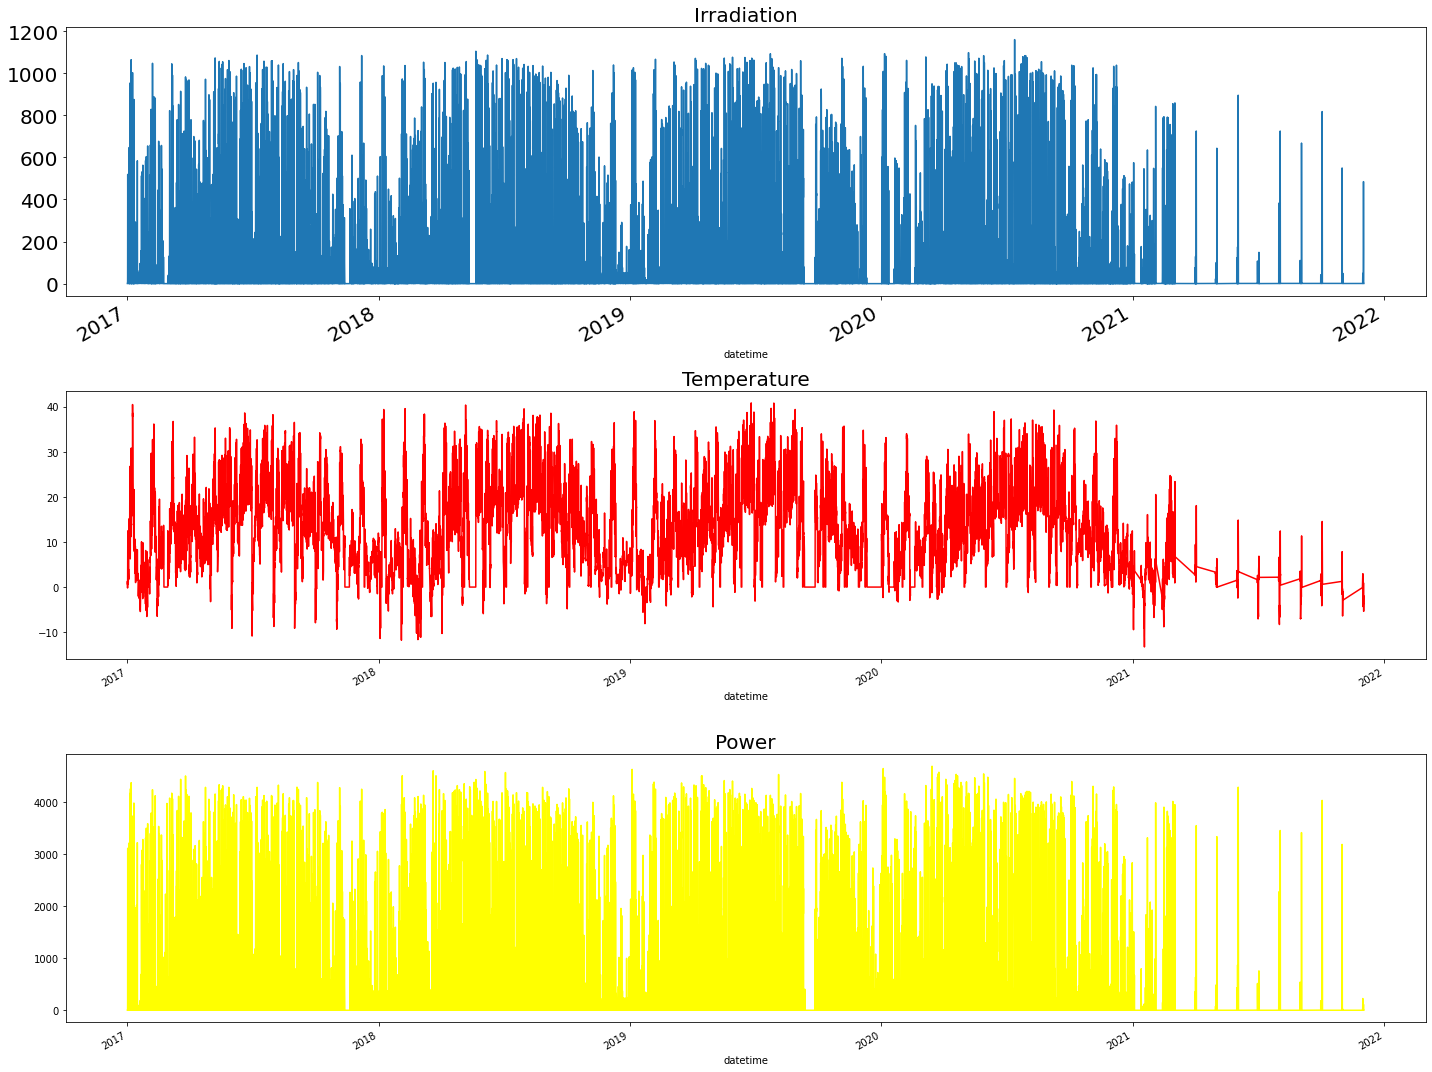

In [160]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.title('Irradiation', fontsize=20)
data['irradiation'].plot(fontsize=20)
plt.subplot(3,1,2)
plt.title('Temperature', fontsize=20)
data['temperature'].plot(c='red')
plt.subplot(3,1,3)
plt.title('Power', fontsize=20)
data['power'].plot(c='yellow')
plt.tight_layout()


- there is a gap data from the measurement during the beginning 2021 to the end of 2022
- for the training purpose, the data will ignore the measurement from 2021 to the end of 2022



In [23]:
# describe the data
data.describe()

,irradiation,temperature,power
count,36720.000000,36720.000000,36720.000000
mean,132.259709,12.313847,622.791982
std,245.840725,9.644382,1102.381376
min,0.000000,-13.273449,0.000000
25%,0.154157,4.418459,0.000000
50%,1.067907,11.496551,0.010766
75%,127.652812,19.225490,691.800067
max,1160.119508,40.830838,4688.205211


In [24]:
# check the detail information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36720 entries, 2017-01-01 00:00:00 to 2021-10-03 23:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   irradiation  36720 non-null  float64
 1   temperature  36720 non-null  float64
 2   power        36720 non-null  float64
dtypes: float64(3)
memory usage: 1.1 MB


# Data preparation

In [28]:
# cut the data 
data_1= data[data.index<='2020-12-31 23:00:00']

In [50]:
data_1.sort_index(inplace=True)

c:\Users\fajrin\python\work_env\lib\site-packages\pandas\core\frame.py:5582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().sort_index(


In [52]:
# split the data 70% for training and 30 % testing
training_size = int(len(data_1)* 0.6)
data_training, data_testing = data_1.iloc[0:training_size,:], data_1.iloc[training_size: int(len(data_1)),:]
print('total data length:{}'.format(len(data_1)))
print('total data training length:{}'.format(len(data_training)))
print('total data testing length:{}'.format(len(data_testing)))

total data length:35064
total data training length:21038
total data testing length:14026


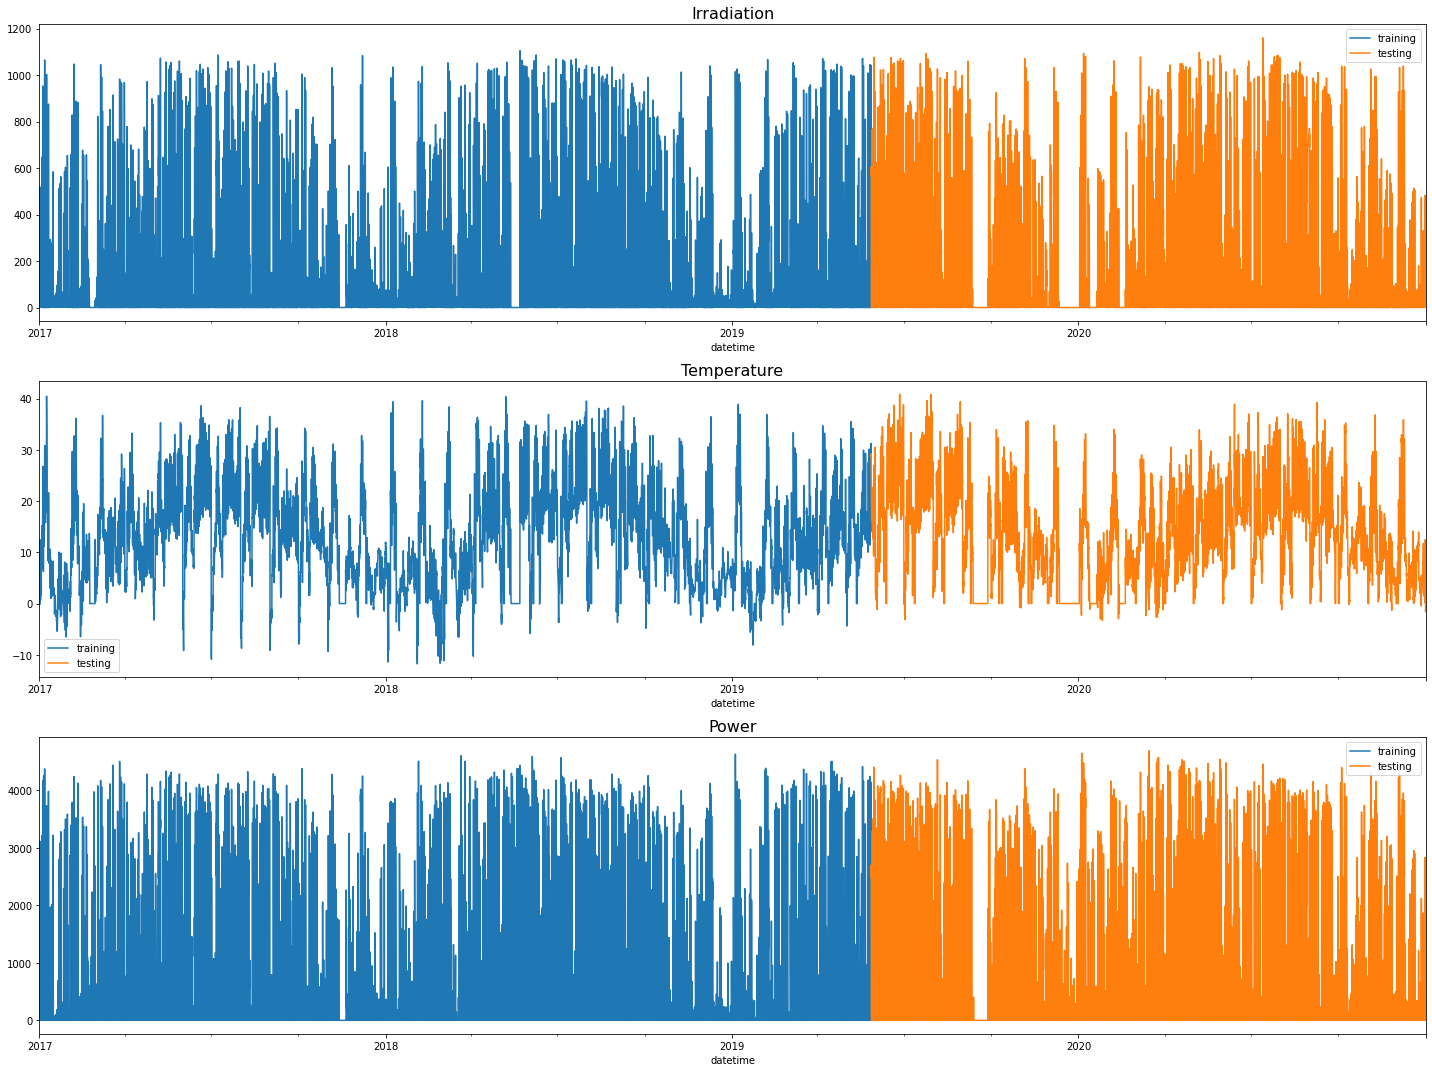

In [60]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.title('Irradiation', fontsize=16)
data_training['irradiation'].plot(label='training')
data_testing['irradiation'].plot(label='testing')
plt.legend()

plt.subplot(3,1,2)
plt.title('Temperature', fontsize=16)
data_training['temperature'].plot(label='training')
data_testing['temperature'].plot(label='testing')
plt.legend()

plt.subplot(3,1,3)
plt.title('Power', fontsize=16)
data_training['power'].plot(label='training')
data_testing['power'].plot(label='testing')
plt.legend()
plt.tight_layout()


# 1. Univariate MLP Models
- in this model, only one feature can be used for forecasting
- irradiation forecasting
- temperature forecasting
- power forecasting


## Data preprocessing
### step : get data > normalize the data > split with window sliding > reshape for model

In [61]:
# get the data
# get the irradiation data
irr_train =data_training['irradiation'].values
irr_test = data_testing['irradiation'].values

#get the temperature data
temp_train = data_training['temperature'].values
temp_test = data_testing['temperature'].values

# get the power data
pow_train = data_training['power'].values
pow_test = data_testing['power'].values

In [86]:
# normalize 
def normalize_data (data):
    data = data.reshape(len(data),1)
    scaler = MinMaxScaler(feature_range=(0,1))
    data_norm= scaler.fit_transform(data)
    return data_norm

# irradiation data normalize
irr_train_norm = normalize_data(irr_train)
irr_test_norm = normalize_data(irr_test)

# temperature data normalize
temp_train_norm = normalize_data(temp_train)
temp_test_norm = normalize_data(temp_test)

# power data normalize
pow_train_norm = normalize_data(pow_train)
pow_test_norm = normalize_data(pow_test)

In [87]:
 # split the sequence
 def split_sequence(sequence, n_steps):
    X= list()
    y = list()
    for i in range (len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) 

# split sequence irradiation
X_train_irr ,y_train_irr  = split_sequence(irr_train_norm,24)
X_test_irr ,y_test_irr  = split_sequence(irr_test_norm,24)

# split sequence temperature
X_train_temp , y_train_temp = split_sequence(temp_train_norm,24)
X_test_temp, y_test_temp = split_sequence(temp_test_norm,24)

# split sequence power
X_train_pow,y_train_pow = split_sequence(pow_train_norm,24)
X_test_pow, y_test_pow = split_sequence(pow_test_norm,24)




In [88]:
# reshape the data
def reshape_data (X,y):
    X = X.reshape(X.shape[0], X.shape[1])
    y = y.flatten()
    return X,y 

# reshape  irradiation
X_train_irr ,y_train_irr =reshape_data(X_train_irr ,y_train_irr)
X_test_irr ,y_test_irr = reshape_data(X_test_irr ,y_test_irr)

# reshape temperature
X_train_temp , y_train_temp = reshape_data(X_train_temp , y_train_temp )
X_test_temp, y_test_temp = reshape_data(X_test_temp, y_test_temp)

# reshape power
X_train_pow,y_train_pow = reshape_data(X_train_pow,y_train_pow)
X_test_pow, y_test_pow = reshape_data(X_test_pow, y_test_pow)

## Define the model
### step: create the model > training model > testing model > check accuracy

In [73]:
# create the keras model
model = Sequential()
model.add(Dense(100, input_dim=X_train_irr.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2500      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 7,601
Trainable params: 7,601
Non-trainable params: 0
_________________________________________________________________


### Univariate irradiation forecasting

In [74]:
hist = model.fit(X_train_irr ,y_train_irr, epochs=100, validation_data=(X_test_irr ,y_test_irr))

Epoch 1/100
657/657 [==============================] - 2s 2ms/step - loss: 0.0055 - accuracy: 0.1114 - val_loss: 0.0040 - val_accuracy: 0.2375
Epoch 2/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 0.1114 - val_loss: 0.0039 - val_accuracy: 0.2375
Epoch 3/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0040 - accuracy: 0.1114 - val_loss: 0.0040 - val_accuracy: 0.2375
Epoch 4/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0039 - accuracy: 0.1114 - val_loss: 0.0037 - val_accuracy: 0.2375
Epoch 5/100
657/657 [==============================] - 2s 2ms/step - loss: 0.0039 - accuracy: 0.1114 - val_loss: 0.0038 - val_accuracy: 0.2375
Epoch 6/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0038 - accuracy: 0.1114 - val_loss: 0.0037 - val_accuracy: 0.2375
Epoch 7/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0038 - accuracy: 0.1114 - val_loss: 0.0041 - val_accuracy: 0.2375

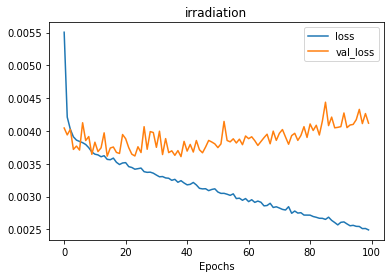

In [111]:
def plot_hist(title,history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.legend()

plot_hist('irradiation',hist)

c:\Users\fajrin\python\work_env\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


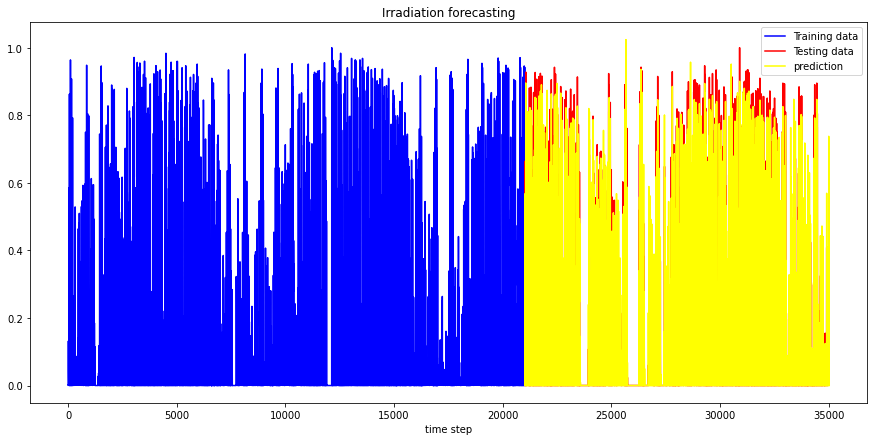

In [107]:
# make a prediction
def plot_pred(title,X_test, y_test,y_train):
    plt.figure(figsize=(15,7)) 
    y_pred = model.predict(X_test)
    plt.plot(y_train, c='blue', label='actual training data')
    plt.plot([None for i in y_train] + [x for x in y_test], c='red', label='actual Testing data')
    plt.plot([None for i in y_train] + [x for x in y_pred], c='yellow', label='prediction testing data')
    
    plt.title(title)
    plt.xlabel('time step')
    plt.legend()

plot_pred('Irradiation forecasting',X_test_irr,y_test_irr,y_train_irr)

### univariate temperature forecasting

In [89]:
hist_temp = model.fit(X_train_temp,y_train_temp,epochs=100, validation_data=(X_test_temp,y_test_temp))

Epoch 1/100
657/657 [==============================] - 2s 3ms/step - loss: 0.0015 - accuracy: 9.5175e-05 - val_loss: 0.0015 - val_accuracy: 1.4284e-04
Epoch 2/100
657/657 [==============================] - 2s 3ms/step - loss: 0.0010 - accuracy: 9.5175e-05 - val_loss: 0.0014 - val_accuracy: 1.4284e-04
Epoch 3/100
657/657 [==============================] - 2s 2ms/step - loss: 9.4144e-04 - accuracy: 9.5175e-05 - val_loss: 0.0013 - val_accuracy: 1.4284e-04
Epoch 4/100
657/657 [==============================] - 2s 2ms/step - loss: 9.2477e-04 - accuracy: 9.5175e-05 - val_loss: 0.0013 - val_accuracy: 1.4284e-04
Epoch 5/100
657/657 [==============================] - 2s 2ms/step - loss: 9.1444e-04 - accuracy: 9.5175e-05 - val_loss: 0.0013 - val_accuracy: 1.4284e-04
Epoch 6/100
657/657 [==============================] - 2s 2ms/step - loss: 9.0339e-04 - accuracy: 9.5175e-05 - val_loss: 0.0013 - val_accuracy: 1.4284e-04
Epoch 7/100
657/657 [==============================] - 1s 2ms/step - loss: 9.0

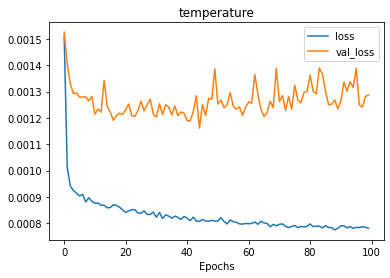

In [112]:
plot_hist('temperature',hist_temp)

c:\Users\fajrin\python\work_env\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


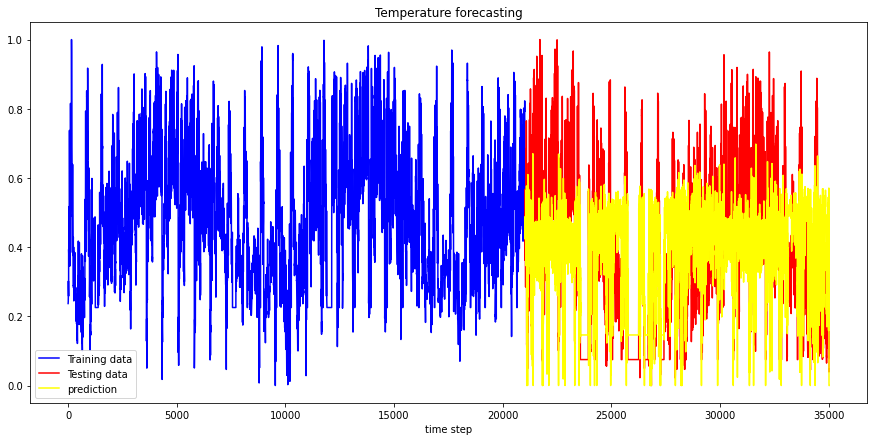

In [108]:
plot_pred('Temperature forecasting',X_test_temp,y_test_temp,y_train_temp)

### Univariate Univariate Power

In [103]:
pow_hist = model.fit(X_train_pow,y_train_pow, epochs=100, validation_data=(X_test_pow,y_test_pow))

Epoch 1/100
657/657 [==============================] - 2s 3ms/step - loss: 0.0052 - accuracy: 0.4833 - val_loss: 0.0054 - val_accuracy: 0.4951
Epoch 2/100
657/657 [==============================] - 2s 2ms/step - loss: 0.0047 - accuracy: 0.4833 - val_loss: 0.0051 - val_accuracy: 0.4951
Epoch 3/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0045 - accuracy: 0.4833 - val_loss: 0.0051 - val_accuracy: 0.4951
Epoch 4/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0045 - accuracy: 0.4833 - val_loss: 0.0050 - val_accuracy: 0.4951
Epoch 5/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0044 - accuracy: 0.4833 - val_loss: 0.0051 - val_accuracy: 0.4951
Epoch 6/100
657/657 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 0.4833 - val_loss: 0.0052 - val_accuracy: 0.4951
Epoch 7/100
657/657 [==============================] - 2s 3ms/step - loss: 0.0043 - accuracy: 0.4833 - val_loss: 0.0051 - val_accuracy: 0.4951

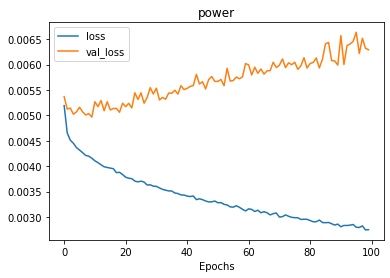

In [113]:
plot_hist('power',pow_hist)

c:\Users\fajrin\python\work_env\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


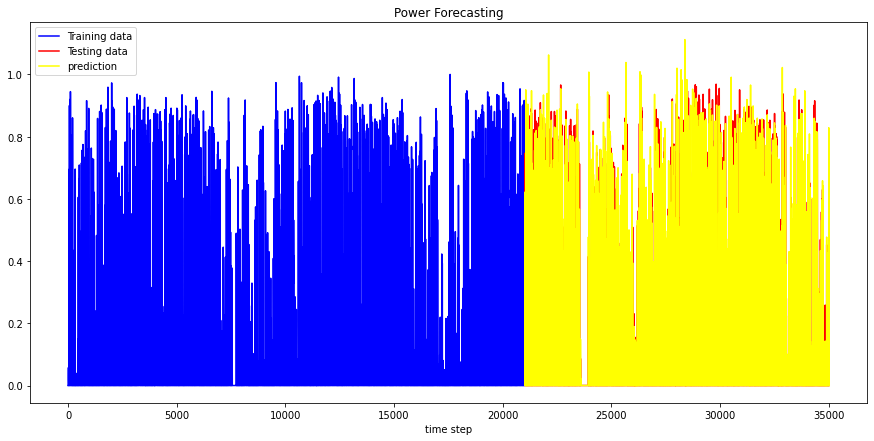

In [109]:
plot_pred('Power Forecasting',X_test_pow,y_test_pow,y_train_pow)